# Dataset Expansion

This is the notebook for expanding the intersection dataset (which was calculated and dumped previously in bechdel_intersection.ipynb to get the intersection of CMU dataset & Bechdel dataset). Now, we additionally add the features we need, that are the following:
* Female Cast Ratio
* Sentiment Analysis (neutral, negative, positive)
* Summary Pronoun Density
* Summary Gender Mention Density
* GII ([Source](https://ourworldindata.org/grapher/gender-inequality-index-from-the-human-development-report?tab=chart))
* HDI ([Source](https://ourworldindata.org/grapher/human-development-index))


## Load the intersection & align the following datasets so that they all have matching Wikipedia movie IDs:
* Plot summaries
* Movie metadata with Bechdel intersection
* Characters metadata

In [21]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [22]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
import json
pd.options.mode.chained_assignment = None
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from textblob import TextBlob
from scipy.stats import spearmanr
from scipy import stats
import os
import sys
import datetime
import requests
from requests_html import HTML
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)



movie_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t')

movie_metadata.columns = ['1. Wikipedia movie ID',
                          '2. Freebase movie ID',
                          '3. Movie name',
                          '4. Movie release date',
                          '5. Movie box office revenue',
                          '6. Movie runtime',
                          '7. Movie languages (Freebase ID:name tuples)',
                          '8. Movie countries (Freebase ID:name tuples)',
                          '9. Movie genres (Freebase ID:name tuples)']

character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t')

character_metadata.columns = ['1. Wikipedia movie ID',
                              '2. Freebase movie ID',
                              '3. Movie release date',
                              '4. Character name',
                              '5. Actor date of birth',
                              '6. Actor gender',
                              '7. Actor height (in meters)',
                              '8. Actor ethnicity (Freebase ID)',
                              '9. Actor name',
                              '10. Actor age at movie release',
                              '11. Freebase character/actor map ID',
                              '12. Freebase character ID',
                              '13. Freebase actor ID']

movie_metadata_bechdel = pd.read_csv("CMU_bechdel_added.csv")
print(movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel.drop("Unnamed: 0", axis=1)
movie_metadata_bechdel["actor_mention_score"] = pd.Series(np.zeros((movie_metadata_bechdel.shape[0],))) #add the new column

character_metadata_bechdel = character_metadata.copy(deep = True)
print("Characters: Size before:", character_metadata_bechdel.shape)
character_metadata_bechdel = character_metadata_bechdel[character_metadata_bechdel['2. Freebase movie ID'].isin(movie_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print("Characters: Size after:", character_metadata_bechdel.shape)

print("Movies: Size before:", movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['2. Freebase movie ID'].isin(character_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print("Movies: Size after:", movie_metadata_bechdel.shape)

(6521, 11)
Characters: Size before: (450668, 13)
Characters: Size after: (72458, 13)
Movies: Size before: (6521, 11)
Movies: Size after: (6202, 11)


In [23]:
plot_summaries=pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['id', 'plot_summary'])
plot_summaries_bechdel = plot_summaries[plot_summaries['id'].isin(character_metadata_bechdel['1. Wikipedia movie ID'].to_numpy())]

plot_summaries.head()
print(plot_summaries.shape)
print(plot_summaries_bechdel.shape)

print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['1. Wikipedia movie ID'].isin(plot_summaries_bechdel["id"].to_numpy())]
print("Movie Metadata After sync:",movie_metadata_bechdel.shape)
display(movie_metadata_bechdel)

(42303, 2)
(5194, 2)
Movie Metadata Before sync: (6202, 11)
Movie Metadata After sync: (5194, 11)


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.0
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.0
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,0.0
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.0
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.0
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.0
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,0.0


## Box Office Scraping, where the hell did all the data go???

To analyse how Bechdel and other woman representation metrics evolved in time with their relevancy towards the industry, box office revenue data is important to consider. However after our initial inspection of the Bechdel intersection dataset in P2, we discovered that only around 45% of the data had box office revenue making it the movie characteristic in CMU with the highest percentage of missing data. We concluded that we need at least 60% of movie information to include box office revenue for a stronger analysis. Therefore, we decided to scrape box office data from https://www.boxofficemojo.com/ to expand our dataframe.

The scraping algorithm was created based on the online tutorial: https://github.com/codingforentrepreneurs/30-Days-of-Python/tree/master/tutorial-reference/Day%2012  The algorithm was adapted to create a single dataframe of all years of box office rather than separate csv files for each year. 

In [24]:
""" def url_to_txt(url, filename="world.html", save=False):
    r = requests.get(url)
    if r.status_code == 200:
        html_text = r.text
        if save:
            with open(f"world-{year}.html", 'w') as f:
                f.write(html_text)
        return html_text
    return None

def parse_and_extract(url, name):
    html_text = url_to_txt(url)
    if html_text == None:
        #print(f"{name} not finished")
        return None
    r_html = HTML(html=html_text)
    table_class = ".imdb-scroll-table"
    r_table = r_html.find(table_class)

    table_data = []
    table_data_dicts = []
    header_names = []
    if len(r_table) == 0:
        return False
    parsed_table = r_table[0]
    rows = parsed_table.find("tr")
    header_row = rows[0]
    header_cols = header_row.find('th')
    header_names = [x.text for x in header_cols]
    for row in rows[1:]:
        cols = row.find("td")
        row_data = []
        row_dict_data = {}
        for i, col in enumerate(cols):
            header_name = header_names[i]
            row_data.append(col.text)
        table_data_dicts.append(row_dict_data)
        table_data.append(row_data)
    df = pd.DataFrame(table_data, columns=header_names)

    return df

def run(start_year, years_ago=0):
    
    df_box_office = pd.DataFrame()
    
    for i in tqdm(range(0, years_ago+1)):
        url = f"https://www.boxofficemojo.com/year/world/{start_year}/"
        #print(f"\ndataframe for year {start_year} is\n")
        
        df = parse_and_extract(url, name=start_year)
            
        df_box_office = pd.concat([df_box_office, df], axis=0)
        start_year += 1
        
    print("\nthe resulted box office dataframe is:")
    display(df_box_office)
    return df_box_office
        

if __name__ == "__main__":
    start=1970 #the boxofficemojo website only has information starting this date
    count=45 #count until the release year of movies in Bechdel intersection dataframe which we consider around 2015
    df_box_office = run(start_year=start, years_ago=count) #dataframe reated that only contain scraped box office information

df_box_office.to_csv("box_office.csv", index=False) """

' def url_to_txt(url, filename="world.html", save=False):\n    r = requests.get(url)\n    if r.status_code == 200:\n        html_text = r.text\n        if save:\n            with open(f"world-{year}.html", \'w\') as f:\n                f.write(html_text)\n        return html_text\n    return None\n\ndef parse_and_extract(url, name):\n    html_text = url_to_txt(url)\n    if html_text == None:\n        #print(f"{name} not finished")\n        return None\n    r_html = HTML(html=html_text)\n    table_class = ".imdb-scroll-table"\n    r_table = r_html.find(table_class)\n\n    table_data = []\n    table_data_dicts = []\n    header_names = []\n    if len(r_table) == 0:\n        return False\n    parsed_table = r_table[0]\n    rows = parsed_table.find("tr")\n    header_row = rows[0]\n    header_cols = header_row.find(\'th\')\n    header_names = [x.text for x in header_cols]\n    for row in rows[1:]:\n        cols = row.find("td")\n        row_data = []\n        row_dict_data = {}\n        for 

We created a new dataframe with more box office revenue information in the column "5. Movie box office revenue". If originally, there is a NaN value in this column and there is a value that was found based on the scraped information, it will be added. 

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
bechdel_score
actor_mention_score
%.1


[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12')]

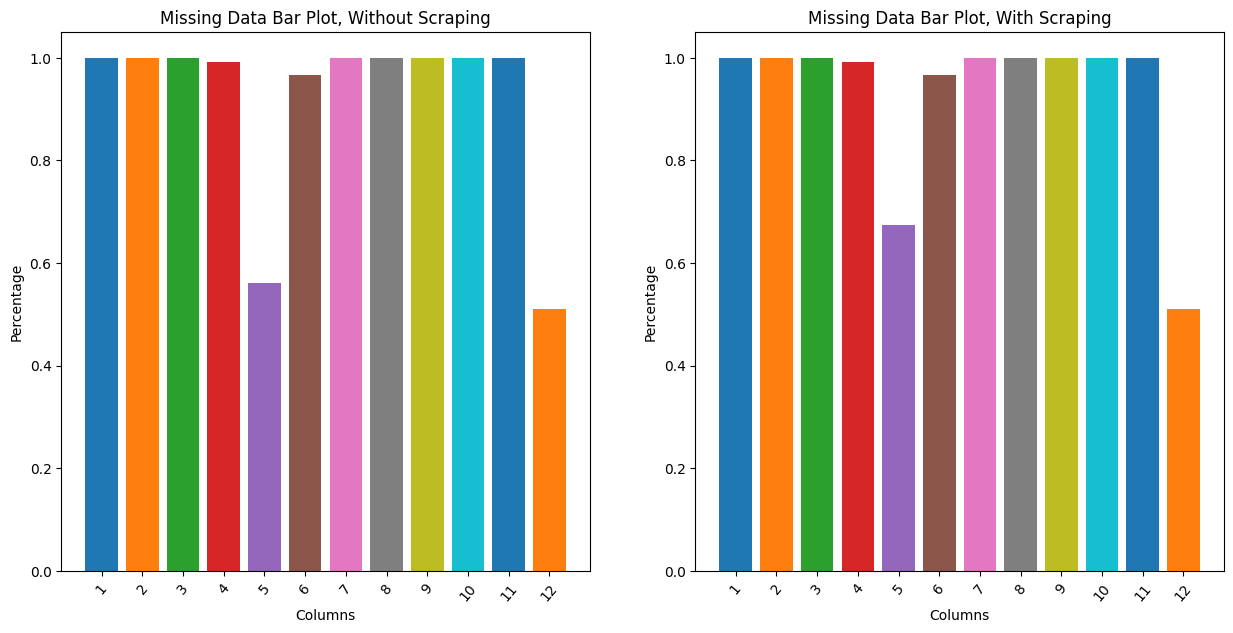

In [25]:
#change the name of movie name column to match our bechdel intersection dataframe
df_box_office=pd.read_csv("box_office.csv")
df_box_office.rename(columns={'Release Group': '3. Movie name'}, inplace=True)

# Drop unnecessary columns
df_box_office = df_box_office.drop(['Rank', '%', '%', 'Domestic', 'Foreign'], axis=1)

# Merge based on the 'ID' column
merged_df = pd.merge(movie_metadata_bechdel, df_box_office, on='3. Movie name', how='left')

#print(f"\nnew movie dataframe:\n")
#display(merged_df)

updated_df = merged_df.copy(deep=True)

# Fill NaN values in '5. Movie box office revenue' with values from 'Worldwide' which is the scraped data information
updated_df['5. Movie box office revenue'] = updated_df['5. Movie box office revenue'].fillna(updated_df['Worldwide'])

# print(f"\nnew movie dataframe with updated 5th column:\n")
# display(updated_df)

merged_df = merged_df.drop('Worldwide',axis=1)
updated_df = updated_df.drop('Worldwide',axis=1)


#display(merged_df)
#display(updated_df)

# Indicator variable showing that something is NA
df_analysis=merged_df.copy(deep=True)
df_analysis["4. Movie release date"]=df_analysis["4. Movie release date"].dropna().astype(str).str[:4]

df_analysis_bechdel=updated_df.copy(deep=True)
df_analysis_bechdel["4. Movie release date"]=df_analysis_bechdel["4. Movie release date"].dropna().astype(str).str[:4]

columns_list=df_analysis.columns
fig,ax= plt.subplots(1,2, figsize=(15,7))


for column_name, index in zip(columns_list, range(0, len(columns_list))):
    print(column_name)

    df_analysis["missing_data"] = df_analysis[column_name].notna()
    mean_missing=df_analysis["missing_data"].mean()

    df_analysis_bechdel["missing_data"] = df_analysis_bechdel[column_name].notna()
    mean_missing_bechdel=df_analysis_bechdel["missing_data"].mean()


    ax[0].bar(column_name,mean_missing)
    ax[1].bar(column_name,mean_missing_bechdel)

ax[0].set_ylabel("Percentage")
ax[0].set_xlabel("Columns")
ax[0].set_title(f"Missing Data Bar Plot, Without Scraping")
ticks = ax[0].get_xticks();  # Get the current tick positions
ax[0].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[0].set_xticklabels(ticks, rotation = 50)

ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Columns")
ax[1].set_title(f"Missing Data Bar Plot, With Scraping")
ticks = ax[1].get_xticks();  # Get the current tick positions
ax[1].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[1].set_xticklabels(ticks, rotation = 50)

# Introduction of Bechdel, what is it? Why is it costly? Can we come up with better approaches?
The Bechdel Test is a simple test to measure the prominence of women in movies. The test consists of three conditions to be satisfied:

1. The cast of the movie contains two women characters,
2. They talk to each other,
3. About a topic besides man

In our bechdel dataset that we scraped from the web(explanation in readme), we have a categorical score between 0 and 3 for each movie indicating how many tests a single movie passes. We then take the intersection between the cmu movie_metadata and the created bechdel dataset.

Although it seems like a good feature for gender representation, getting the data might be very costly. This is primarily because it involves processing the entire movie script either by humans or complex natural language processing models. In this project, we will introduce new metrics that can be gotten just from the movie summaries, therefore reducing the dramatically the complexity of the latter task. We will then try to see the possible correlations between these metrics and the bechdel score determining the importance of each metric. By doing this, we aim to come up with a new simpler to get formula that may be a better gender representer by combining our new metrics. We will finally observe these new metrics' evolution with each country 

## Metric 1:  Gender Mention Density
We calculate the following simple ratio:
$$\frac{number_{female\_characters}}{number_{female\_characters} + number_{male\_characters}}$$

For each unique movie, we access its relative character dataframe and the summary provided. By comparing every name in the summary, we get their genders and calculate the abovementioned score.

In [26]:
def calculate_actor_mention_score(movie_idx):
    movie_summary = plot_summaries_bechdel.iloc[movie_idx]["plot_summary"]
    
    #Tokenize the movie summary
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(movie_summary)
    tokens = [x.lower() for x in tokens]
    tokens_freq = pd.Series(tokens).value_counts(sort=True)
    
    #align movie dataset & character dataset
    movie_id = plot_summaries_bechdel.iloc[movie_idx]["id"]
    character_list = character_metadata_bechdel[character_metadata_bechdel['1. Wikipedia movie ID'] == movie_id][['4. Character name','6. Actor gender']]
    
    character_list_processed = character_list.copy()
    character_list_processed = character_list_processed.dropna()

    #Lowercase character names
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.lower()

    #Split full name and only get the first name
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.split(' ').str[0]

    character_list_processed = character_list_processed.drop(character_list_processed[character_list_processed["4. Character name"] == "the"].index)

    character_gender_stacked = character_list_processed.drop_duplicates(subset='4. Character name', keep=False)
    character_gender_stacked_idx = character_gender_stacked.set_index("4. Character name")

    #Take the intersection between the token's frequency and movie cast
    tokens_intersection = tokens_freq[character_gender_stacked_idx.index.intersection(tokens_freq.index)]
    character_gender_stacked = character_gender_stacked.drop_duplicates()
    character_mention_freq = character_gender_stacked[character_gender_stacked["4. Character name"].isin(tokens_intersection.index)]#.drop_duplicates()

    #Add the number of character mentions in summary to the character meta-dataset
    character_mention_freq["no_mention"] = tokens_intersection.values#pd.DataFrame({'4. Character name':character_mention_freq[0], 'no_mention':character_mention_freq.values})
    character_mention_freq.columns = ["character_name", "gender", "no_mention"]
    character_list_final = character_mention_freq
    #print(character_list_final)
    
    #Group by gender and calculate total number of mentions by gender
    character_list_freq_added = character_list_final.groupby(['gender']).sum()
    if len(character_list_freq_added['no_mention'].index) != 0:
        if character_list_freq_added['no_mention'].shape[0] == 2:
            female_mention, male_mention = character_list_freq_added['no_mention'].iloc[0], character_list_freq_added['no_mention'].iloc[1] #groupby is alphabethic, index 0 = F
            mention_ratio = female_mention/(female_mention + male_mention)
        elif character_list_freq_added['no_mention'].index[0] == "M":
            mention_ratio = 0.
        elif character_list_freq_added['no_mention'].index[0] == "F":
            mention_ratio = 1.
        else:
            mention_ratio = np.nan
    else:
        mention_ratio = np.nan

    actor_mention_score = round(mention_ratio, 4)
    
    return actor_mention_score, movie_id


In [27]:
beginning = time.time()

for a in tqdm(range(movie_metadata_bechdel.shape[0]-1)):
    actor_mention_score, movie_id = calculate_actor_mention_score(a+1)
    
    movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"] = actor_mention_score

100%|██████████| 5193/5193 [00:19<00:00, 265.51it/s]


In [28]:
display(movie_metadata_bechdel)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,NaN
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,NaN


In the barplot below, the simple toddler would see that with increasing actor mention scores, the bechdel score also improves. We will try to see if that correlation is significant in the later steps.

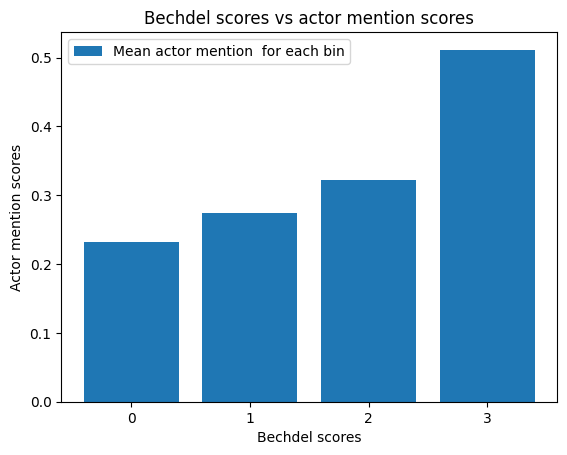

In [29]:
movie_metadata_bechdel=movie_metadata_bechdel.dropna(subset="actor_mention_score")
mention_group=movie_metadata_bechdel.groupby("bechdel_score")["actor_mention_score"].mean()

x=mention_group.index
plt.bar(x, mention_group.values, tick_label=x, label="Mean actor mention  for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Actor mention scores")
plt.title("Bechdel scores vs actor mention scores")
plt.legend()
plt.show()

Furthering our analysis, we now plot the distribution again the bechdel score by taking the mean bechdel score of each bin of the actor mention score. Now the correlation is now much more visible and understandable. We have lower bechdel scores for cases where female characters were less mentioned and higher bechdel scores when they are mentioned more.

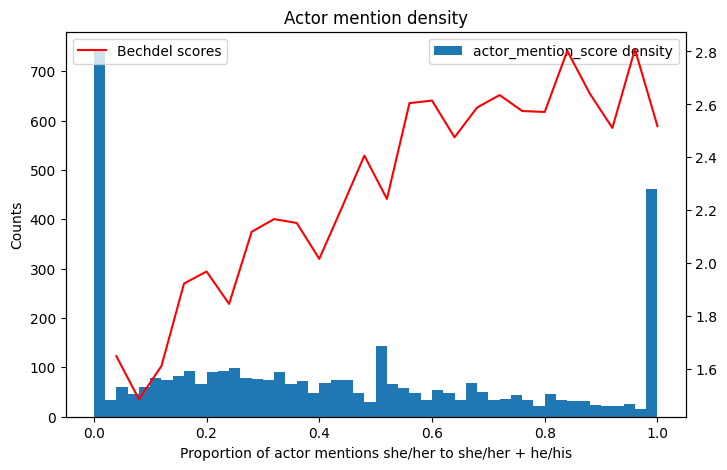

In [30]:
sorted_mentions = movie_metadata_bechdel.sort_values('actor_mention_score')
bins =  np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_mentions['actor_mention_score'], bins)
    
bechdel_means=sorted_mentions.groupby(ind)["bechdel_score"].mean()

fig, ax= plt.subplots(1,1, figsize=(8,5))
ax.hist(movie_metadata_bechdel["actor_mention_score"], bins=50, label='actor_mention_score density')
ax.set_xlabel("Proportion of actor mentions she/her to she/her + he/his")
ax.set_ylabel("Counts")
ax.set_title("Actor mention density")
ax2 = ax.twinx()
ax2.plot(bechdel_means.index/25,bechdel_means, color='red', label='Bechdel scores')
ax.legend()
ax2.legend()



Now its time for the metric to shine (hopefully). We first do a linear regression using Ordinary Least squares (OLS) between the bechdel score taking it as a dependent variable and taking the actor mention score as an independent variable. We observe an adjusted R squared value of 0.112 which might not seem very high but the probability of observing the regression coefficient is significant for a p value of p=0.01. in fact the system displays it as 0 for two decimal points meaning it is very small that it is rounded down. 

To better understand the correlation we employ the spearman correlation to that also that is not limited by linear correlations. For the latter we get a correlation coefficient of 0.35 which doesn't look bad. However the very small p value that we get is probably from the size effect of the data.

From these analysis we assume that this might be a good metric to predict the bechdel score.

In [31]:
results_mentions = smf.ols('bechdel_score ~ actor_mention_score', data=movie_metadata_bechdel).fit()
print(results_mentions.summary())

spearman_corr_mentions = spearmanr(movie_metadata_bechdel['bechdel_score'], movie_metadata_bechdel['actor_mention_score'])

print(f"Spearman correlation: {spearman_corr_mentions}")

                            OLS Regression Results                            
Dep. Variable:          bechdel_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     493.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          5.43e-103
Time:                        18:21:12   Log-Likelihood:                -5521.4
No. Observations:                3913   AIC:                         1.105e+04
Df Residuals:                    3911   BIC:                         1.106e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7149    

## Metric 2: Female Cast Ratio

We calculate the female cast ratio, defined by [(Yang et al., 2020)](https://doi.org/10.1145/3411213). This is relatively easy to understand and thus implement. For each movie in our dataset, we get their relative character metadata and calculate the ratio of female to total cast.

In [32]:
unique_count_wiki = character_metadata_bechdel['1. Wikipedia movie ID'].nunique()
unique_count_freebase = character_metadata_bechdel['2. Freebase movie ID'].nunique()
print("Number of unique Wikipedia movie ID values:", unique_count_wiki)
print("Number of unique Freebase movie ID values:", unique_count_freebase)

Number of unique Wikipedia movie ID values: 6202
Number of unique Freebase movie ID values: 6202


In [33]:
#Group by 1. Wikipedia movie ID and 6. Actor gender, then count the occurrences of each gender
gender_counts = character_metadata_bechdel.groupby(['1. Wikipedia movie ID', '6. Actor gender']).size().unstack(fill_value=0)

#Calculate the ratio of female actors to total actors for each movie
gender_counts['female_ratio'] = gender_counts['F'] / (gender_counts['M'] + gender_counts['F'])
gender_counts = gender_counts.reset_index().drop(columns = ["F", "M"])

#merge the gender_counts and character_metadata_bechdel
movie_metadata_bechdel_fcr = pd.merge(movie_metadata_bechdel, gender_counts, on='1. Wikipedia movie ID', how="left")

In [34]:
display(movie_metadata_bechdel_fcr)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score,female_ratio
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500,0.150000
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345,0.461538
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830,0.428571
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,1.0000,0.250000
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,0.2500,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,0.2222,0.294118
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500,0.235294
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667,0.454545
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200,0.285714


### Plotting with the female cast ratio

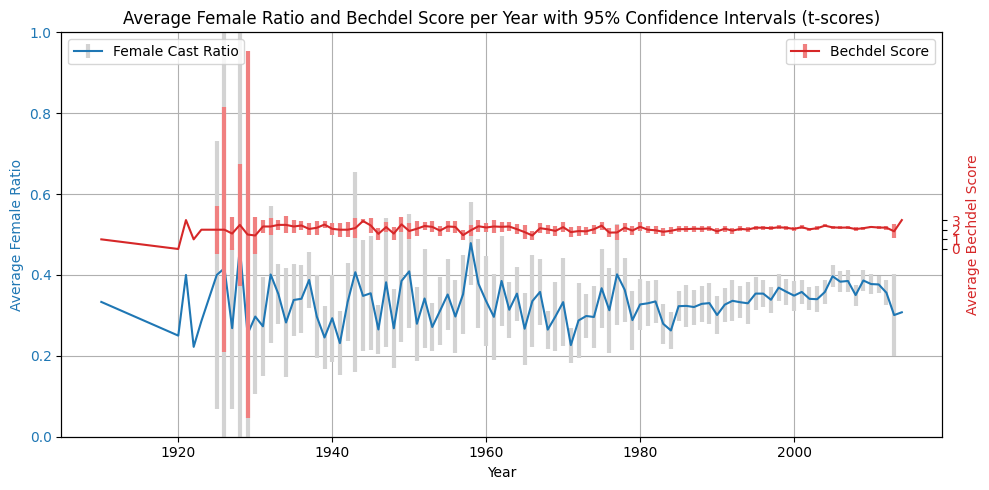

In [35]:
# Assuming 'bechdel_score' is the column that contains the Bechdel scores
from scipy.stats import sem, t

movie_metadata_bechdel_fcr['year'] = movie_metadata_bechdel_fcr['4. Movie release date'].astype(str).str[:4]
movie_metadata_bechdel_fcr['year']= pd.to_numeric(movie_metadata_bechdel_fcr['year'], errors='coerce')

#Calculate the mean, lower, and upper confidence bounds for female cast ratio
average_female_ratio_per_year = movie_metadata_bechdel_fcr.groupby('year').agg(
    avg_female_ratio=('female_ratio', 'mean'),
    lower_bound=('female_ratio', lambda x: x.mean() - (t.ppf(0.975, x.count()-1) * sem(x))),
    upper_bound=('female_ratio', lambda x: x.mean() + (t.ppf(0.975, x.count()-1) * sem(x)))
).reset_index()

#Calculate the mean, lower, and upper confidence bounds for Bechdel score
average_bechdel_per_year = movie_metadata_bechdel_fcr.groupby('year').agg(
    avg_bechdel_score=('bechdel_score', 'mean'),
    lower_bechdel=('bechdel_score', lambda x: x.mean() - (t.ppf(0.975, x.count()-1) * sem(x))),
    upper_bechdel=('bechdel_score', lambda x: x.mean() + (t.ppf(0.975, x.count()-1) * sem(x)))
).reset_index()

#Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 5))

# lot the female cast ratio on the primary y-axis
ax1.errorbar(average_female_ratio_per_year['year'], average_female_ratio_per_year['avg_female_ratio'], 
             yerr=[average_female_ratio_per_year['avg_female_ratio'] - average_female_ratio_per_year['lower_bound'], 
                   average_female_ratio_per_year['upper_bound'] - average_female_ratio_per_year['avg_female_ratio']],
             fmt='-', label='Female Cast Ratio', ecolor='lightgray', elinewidth=3, capsize=0)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Female Ratio', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1) # Assuming female ratio is between 0 and 1
ax1.grid(True)

#Create the secondary y-axis for the Bechdel score
ax2 = ax1.twinx()
ax2.errorbar(average_bechdel_per_year['year'], average_bechdel_per_year['avg_bechdel_score'],
             yerr=[average_bechdel_per_year['avg_bechdel_score'] - average_bechdel_per_year['lower_bechdel'],
                   average_bechdel_per_year['upper_bechdel'] - average_bechdel_per_year['avg_bechdel_score']],
             fmt='-', label='Bechdel Score', ecolor='lightcoral', elinewidth=3, capsize=0, color='tab:red')
ax2.set_ylabel('Average Bechdel Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1, 2, 3])

plt.title('Average Female Ratio and Bechdel Score per Year with 95% Confidence Intervals (t-scores)')
plt.tight_layout()

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


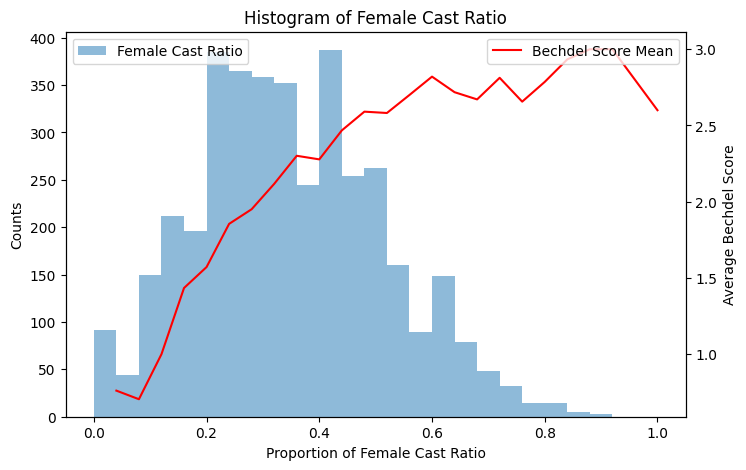

In [36]:
# Sorting the data by female cast ratio
sorted_fcr = movie_metadata_bechdel_fcr.sort_values('female_ratio')

# Creating bins for the female cast ratio
bins = np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_fcr['female_ratio'], bins)

# Grouping by bins and calculating the mean Bechdel score for each bin
bechdel_means = sorted_fcr.groupby(ind)["bechdel_score"].mean()

# Creating a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Plotting the histogram of the female cast ratio
ax.hist(movie_metadata_bechdel_fcr["female_ratio"], bins=bins, label='Female Cast Ratio', alpha=0.5)

# Setting the x-axis label, y-axis label, and title for the histogram
ax.set_xlabel("Proportion of Female Cast Ratio")
ax.set_ylabel("Counts")
ax.set_title("Histogram of Female Cast Ratio")

# Creating a secondary y-axis for the Bechdel score
ax2 = ax.twinx()

# Plotting the Bechdel scores
ax2.plot(bechdel_means.index/25, bechdel_means, color='red', label='Bechdel Score Mean')

# Setting the y-axis label for the Bechdel scores
ax2.set_ylabel("Average Bechdel Score")

# Adding the legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.show()


## Metric 3: Summary Pronoun Density
Here, we check the density of gender related pronouns in the plot summary we have. After we tokenize the data, we search through the tokens for the frequency of the "she" & "her", compared to frequency of "he" & "him". Then, we simple calculate the following ratio:

$$density_{pronoun} = \frac{number_{she,her}}{number_{she,her} + number_{he,his}}$$



In [37]:

print(plot_summaries.shape)
tokenizer = RegexpTokenizer(r'\w+')
counts=[{"1. Wikipedia movie ID":0,"she":0, "her":0, "he":0, "his":0} for i in range(plot_summaries.shape[0])]

for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    tokens = tokenizer.tokenize(row[1])
    counts[i]["1. Wikipedia movie ID"]=row[0]
    counts[i]["she"]=tokens.count("she")
    counts[i]["her"]=tokens.count("her")
    counts[i]["he"]=tokens.count("he")
    counts[i]["his"]=tokens.count("his")

(42303, 2)


  0%|          | 0/42303 [00:00<?, ?it/s]C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3245972499.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tokens = tokenizer.tokenize(row[1])
C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3245972499.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts[i]["1. Wikipedia movie ID"]=row[0]
100%|██████████| 42303/42303 [00:04<00:00, 8829.03it/s]


In [38]:
genders=pd.DataFrame(counts)
genders["gender_density"]=(genders['she'] + genders['her']) / (genders['she'] + genders['her'] + genders['he'] + genders['his'])
genders_only = genders.drop(columns = ["she", "her", "he", "his"])
movie_metadata_bechdel_fcr_pronoun = pd.merge(movie_metadata_bechdel_fcr, genders, on='1. Wikipedia movie ID', how='left')

display(movie_metadata_bechdel_fcr_pronoun)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score,female_ratio,year,she,her,he,his,gender_density
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500,0.150000,1989.0,0,0,0,1,0.000000
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345,0.461538,1964.0,7,9,12,20,0.333333
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830,0.428571,1989.0,2,4,8,11,0.240000
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,1.0000,0.250000,1968.0,13,20,3,2,0.868421
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,0.2500,0.285714,1984.0,3,3,1,3,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,0.2222,0.294118,1996.0,0,7,2,2,0.636364
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500,0.235294,2011.0,4,2,11,12,0.206897
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667,0.454545,1997.0,1,0,8,9,0.055556
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200,0.285714,1988.0,0,6,10,13,0.206897


## What!!!!? Films really mention more males???
Here we first plot the distribution of the pronoun density versus the bechdel score. We can immediately see that a great number of films in the first bin corresponding to a she/her mention of a very low level to 0. When plotting this against the average bechdel test scores for each mean, we observe a visual correlation, meaning for low mentions of females the bechdel score is lower and for mention of females the bechdel score is higher. This result is consistent to what we saw in the beginning of this notebook with the evolution of the female cast ratio over the years. Finally we plot the individual occurences of each pronoun in each plot summary. We then conduct an independent t test telling us that the probability of observing male pronouns versus females are considerably different at a significance level of p=0.001

TtestResult(statistic=-8.596201446972522, pvalue=9.845697729021128e-18, df=7824.0)


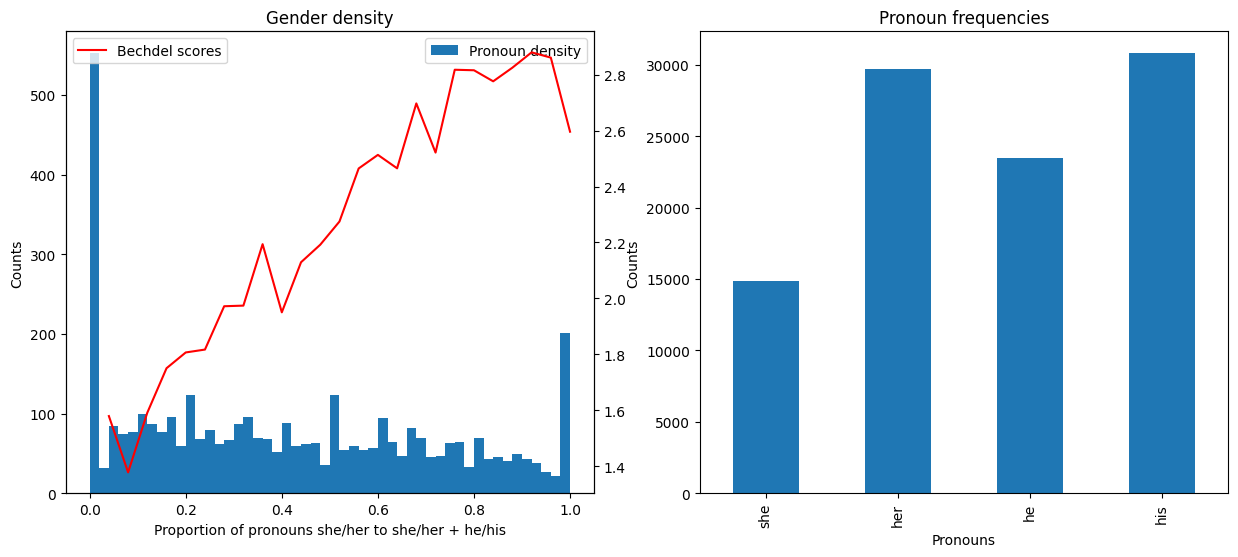

In [39]:
sorted_genders = movie_metadata_bechdel_fcr_pronoun.sort_values('gender_density')
bins =  np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_genders['gender_density'], bins)
    
bechdel_means=sorted_genders.groupby(ind)["bechdel_score"].mean()

fig, ax= plt.subplots(1,2, figsize=(15,6))
ax[0].hist(movie_metadata_bechdel_fcr_pronoun["gender_density"], bins=50, label='Pronoun density')
ax[0].set_xlabel("Proportion of pronouns she/her to she/her + he/his")
ax[0].set_ylabel("Counts")
ax[0].set_title("Gender density")
ax2 = ax[0].twinx()
ax2.plot(bechdel_means.index/25,bechdel_means, color='red', label='Bechdel scores')
ax[0].legend()
ax2.legend()


genders_sum=movie_metadata_bechdel_fcr_pronoun[["she","her", "he", "his"]].sum()
genders_sum.plot(kind='bar',ax=ax[1])
ax[1].set_xlabel("Pronouns")
ax[1].set_ylabel("Counts")
ax[1].set_title("Pronoun frequencies")

female_pronouns = movie_metadata_bechdel_fcr_pronoun["she"] + movie_metadata_bechdel_fcr_pronoun["her"]
male_pronouns = movie_metadata_bechdel_fcr_pronoun["he"] + movie_metadata_bechdel_fcr_pronoun["his"]

# Perform independent t-test
gender_stats = stats.ttest_ind(female_pronouns, male_pronouns)
print(gender_stats)



## Metric 4: Sentiment Analysis

In this section, we obtain the mood of the summary provided, by using the Roberta model, trained on Twitter, and running the model with the tokenized summary. With this method, we do not need the  preprocessing of our summary, such as stop-word-removal, etc. In return, we get the probabilities of the following three moods:
1. Negative
2. Neutral
3. Positive

In [40]:
"""MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)


scores_final=[]
for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    encoded_text = tokenizer(row[1], return_tensors='pt', truncation=True, max_length=512).to(device)

    output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()

    scores = softmax(scores)

    scores_dict = {
        'index': row[0],
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }
    scores_final.append(scores_dict)
    
sentiments=scores_final.copy()
sentiments=pd.DataFrame(sentiments)
sentiments.to_csv("sentiment_analysis.csv", index=False)"""
sentiments=pd.read_csv("sentiment_analysis.csv")

## Oh man! That movie was really sentimental! Or is it?

When we plot the sentiment analysis results for all the movies in our initial cmu dataset, we clearly see that neutral movies make the substantial majority with the negative movies coming in for the second place and the positive movies for the last. Although the difference is visually very visible, we nevertheless perform a t test. As a result we see that the probability of having neutral scores are statistically different than observing a positive or a negative score at a significance level of p=0.01 

TtestResult(statistic=480.7956324949688, pvalue=0.0, df=84604.0)
TtestResult(statistic=165.7254445862797, pvalue=0.0, df=84604.0)


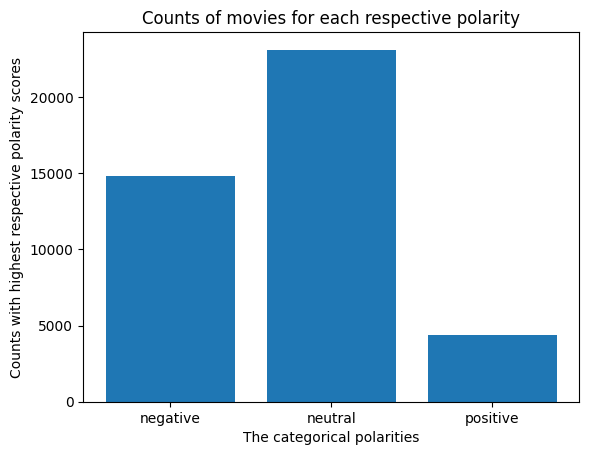

In [41]:
sentiments=sentiments.dropna()
sentiment_counts = sentiments[["negative", "neutral", "positive"]].sum()
plt.bar(["negative","neutral","positive"], sentiment_counts.values)
plt.xlabel("The categorical polarities")
plt.ylabel("Counts with highest respective polarity scores")
plt.title("Counts of movies for each respective polarity")

neu_pos = stats.ttest_ind(sentiments["neutral"], sentiments["positive"])
print(neu_pos)
neu_neg = stats.ttest_ind(sentiments["neutral"], sentiments["negative"])
print(neu_neg)

### Getting the polarity scores from text_blob
Since the roberta model only gives categorical scores that add up to 1 and not the polarity score, we will calculate the roberta polarity by substracting the negative score from the positive score. But first to set a baseline for our approach we calculate directly the polarity scores by using the library Textblob, the roberta polarity will be calculated after.

In [42]:
polarity_scores_final=[]
for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    #print(i)
    blob=TextBlob(row[1])
    polarity_scores = {
        'index': row[0],
        'sentiment_polarity_blob': blob.sentiment[0],
    }
    polarity_scores_final.append(polarity_scores)

polarities=polarity_scores_final.copy()
polarities=pd.DataFrame(polarity_scores_final)
polarities.to_csv("polarities.csv", index=False)


  0%|          | 0/42303 [00:00<?, ?it/s]C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3081513322.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  blob=TextBlob(row[1])
C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3081513322.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'index': row[0],
100%|██████████| 42303/42303 [00:50<00:00, 833.56it/s] 


In [43]:
display(polarities)

,index,sentiment_polarity_blob
0,23890098,0.200000
1,31186339,0.045261
2,20663735,0.049550
3,2231378,0.030550
4,595909,0.063913
...,...,...
42298,34808485,0.146667
42299,1096473,0.155081
42300,35102018,0.156000
42301,8628195,0.104762


Below we merge our textblob and roberta results with the intersection dataset with bechdel, we also do calculate the Roberta Polarities as indicated above

In [44]:
sentiments_sync = sentiments[sentiments["index"].isin(movie_metadata_bechdel_fcr_pronoun["1. Wikipedia movie ID"])]
sentiments_sync.columns = ["1. Wikipedia movie ID", "negative", "neutral", "positive"]
movie_metadata_bechdel_fcr_pronoun_sentiment = pd.merge(movie_metadata_bechdel_fcr_pronoun, sentiments_sync, on='1. Wikipedia movie ID', how="left")
print("After sentiment scores added:",movie_metadata_bechdel_fcr_pronoun.shape)

polarities_sync = polarities[polarities["index"].isin(movie_metadata_bechdel_fcr_pronoun_sentiment["1. Wikipedia movie ID"])]
polarities_sync.columns = ["1. Wikipedia movie ID", "polarity_bob"]
movie_metadata_bechdel_fcr_pronoun_sentiment = pd.merge(movie_metadata_bechdel_fcr_pronoun_sentiment, polarities_sync, on='1. Wikipedia movie ID', how="left")
movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_roberta"]=movie_metadata_bechdel_fcr_pronoun_sentiment["positive"]-movie_metadata_bechdel_fcr_pronoun_sentiment["negative"]

movie_metadata_bechdel_fcr_pronoun_sentiment=movie_metadata_bechdel_fcr_pronoun_sentiment.dropna(subset=["bechdel_score", "actor_mention_score", "polarity_bob", "polarity_roberta", "gender_density"])
display(movie_metadata_bechdel_fcr_pronoun_sentiment)


After sentiment scores added: (3913, 18)


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,...,she,her,he,his,gender_density,negative,neutral,positive,polarity_bob,polarity_roberta
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,...,0,0,0,1,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,...,7,9,12,20,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,...,2,4,8,11,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,...,13,20,3,2,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,...,3,3,1,3,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,...,0,7,2,2,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,...,4,2,11,12,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,...,1,0,8,9,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,...,0,6,10,13,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617


### Spearman correlations between different metrics including roberta and bob polarities

In [45]:


spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_bob'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_roberta'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_bob'], movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_roberta'], movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_bob'], movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_roberta'], movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'], movie_metadata_bechdel_fcr_pronoun_sentiment['bechdel_score'])
print(spearman_corr, spearman_p_value)

spearman_corr, spearman_p_value = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'], movie_metadata_bechdel_fcr_pronoun_sentiment['bechdel_score'])
print(spearman_corr, spearman_p_value)

0.4108121650782154 6.322915976358837e-157
0.11865080790591404 1.4511877829017823e-13
0.10724932145031754 2.4399106018301538e-11
0.11503295822725695 7.798818749873152e-13
0.12751695686148015 1.891173459785128e-15
0.4448129036750539 8.952674005450154e-187
0.3497483125755255 2.341831558362662e-111


In [46]:
import plotly.offline as offline
import plotly.figure_factory as ff


import numpy as np


x = movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_bob"]
y = movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_roberta"]

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

fig = ff.create_2d_density(
    x, y, colorscale=colorscale,
    hist_color='rgb(255, 237, 222)', point_size=3
)

# Update layout to add titles
fig.update_layout(
    xaxis_title="Bob polarity",
    yaxis_title="Roberta polarity"
)

# For an interactive plot in an IPython notebook
offline.iplot(fig, filename='histogram_subplots')

neu_neg = stats.ttest_ind(x, y)
print(neu_neg)

TtestResult(statistic=83.20405121004995, pvalue=0.0, df=7710.0)


## Auxililary Features

We added the binary bechdel test for further analysis.

In [47]:
movie_metadata_bechdel_fcr_pronoun_sentiment["bechdel_binary"] = (movie_metadata_bechdel_fcr_pronoun_sentiment["bechdel_score"] == 3).astype(int)

In [48]:
display(movie_metadata_bechdel_fcr_pronoun_sentiment)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,...,her,he,his,gender_density,negative,neutral,positive,polarity_bob,polarity_roberta,bechdel_binary
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,...,0,0,1,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788,1
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,...,9,12,20,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073,1
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,...,4,8,11,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774,1
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,...,20,3,2,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499,1
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,...,3,1,3,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,...,7,2,2,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146,1
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,...,2,11,12,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408,0
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,...,0,8,9,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087,1
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,...,6,10,13,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617,1


In [49]:
#Dump final dataset to csv file
movie_metadata_bechdel_fcr_pronoun_sentiment.to_csv("movie_metadata_all_features.csv", index=False)

## Bechdel Analysis: GII & HDI Addition

To further analyze the dataset and relations with Bechdel score, we introduce Gender Inequality Index (GII) and Human Development Index (HDI) to our dataset. This way, we can carry out an analysis based on the countries.
([Source for GII](https://ourworldindata.org/grapher/gender-inequality-index-from-the-human-development-report?tab=chart))
([Source for HDI](https://ourworldindata.org/grapher/human-development-index))

In [50]:
# Load Data
bechdel_movies = pd.read_csv('CMU_bechdel_added.csv')

GII = pd.read_csv('gender-inequality-index-from-the-human-development-report.csv')
HDI = pd.read_csv('human-development-index.csv')

#Add Country Names
bechdel_movies['country_names'] = bechdel_movies['8. Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: list(json.loads(x).values()))

# If some movie is created in diferent countries it will create new rows for each country 
bechdel_movies = bechdel_movies.explode('country_names')

# Group by Country
grouped_by_country = bechdel_movies.groupby('country_names').size().sort_values().reset_index(name="Movie Count")

# Just show if 
filt_grouped_by_country = grouped_by_country[grouped_by_country['Movie Count']>20]


#TAKE OUT MOVIES WITHOUT RELEASE DATE OR/AND COUNTRY
# Bechdel Test and GII, we need to take out the data that doesn't have country or date of release
bechdel_movies_filt = bechdel_movies[~(bechdel_movies['4. Movie release date'].isnull() | 
                                       (bechdel_movies['8. Movie countries (Freebase ID:name tuples)'] == '{}'))]

print("\nWe pass from " + str(len(bechdel_movies['1. Wikipedia movie ID'].unique())) + ' movies to '+ 
      str(len(bechdel_movies_filt['1. Wikipedia movie ID'].unique())) + " movies that don't have release date or country" )

# Take off the nan values and just see the first 4 numbers (years)
bechdel_movies_filt['Year'] = bechdel_movies_filt['4. Movie release date'].astype(str).str[:4]
bechdel_movies_filt['Year'] = bechdel_movies_filt['Year'].astype(int)


# Combine the HDI and GII dataframes
merge_HDI_GII = pd.merge(HDI, GII, on = ['Entity','Year','Code'], how = 'left')
merge_HDI_GII['Year'] = merge_HDI_GII['Year'].astype(int)


bechdel_movies_filt = bechdel_movies_filt.rename(columns = {'country_names': 'Entity'})
#display(bechdel_movies_filt)

# Add the Code on bechdel_movies_filt
df_entityCode = merge_HDI_GII.loc[:,('Entity','Code')]
df_entityCode = df_entityCode.drop_duplicates(['Entity','Code'])
df_entityCode['Entity'] = df_entityCode['Entity'].replace('United States','United States of America')
merged = pd.merge(bechdel_movies_filt,df_entityCode, on = ['Entity'], how='left')
#display(merged)

# Print how many movies don't have Code 
nan_countries = merged[merged['Code'].isna()]
nan_countries_n = nan_countries['Entity'].unique()
nan_countries_movies = nan_countries['1. Wikipedia movie ID'].unique()

print("\nThere is " + str(len(nan_countries_n)) + ' countries that are not inside the Dataframe HDI and GII:')
print(nan_countries_n)
print('Corresponding to ' + str(len(nan_countries_movies)) + ' movies')

# Drop the movies that dont have data on merge_HDI_GII
merged = merged[~(merged['Code'].isna())]

# Merge the Bechdel Test with HDI and GII
merged_data = pd.merge(merged, merge_HDI_GII, on = ['Year','Entity','Code'], how = 'left')

# The out the nan from HDI or GII
final = merged_data[(~merged_data['Human Development Index'].isna())|(~merged_data['Gender Inequality Index'].isna())]

n_final_movies = final['1. Wikipedia movie ID'].unique()
print("\nThere is " + str(len(n_final_movies)) + ' countries with HDI and/or GII')
      
display(final)


We pass from 6521 movies to 6239 movies that don't have release date or country

There is 20 countries that are not inside the Dataframe HDI and GII:
['Yugoslavia' 'Soviet Union' 'West Germany' 'England' 'Czech Republic'
 'Serbia and Montenegro' 'Czechoslovakia' 'German Democratic Republic'
 'Weimar Republic' 'Scotland' 'Taiwan' 'Democratic Republic of the Congo'
 'Korea' 'Northern Ireland' 'Kingdom of Great Britain'
 'Palestinian territories' 'Mandatory Palestine' 'Slovak Republic'
 'Puerto Rico' 'Kingdom of Italy']
Corresponding to 174 movies

There is 1839 countries with HDI and/or GII


,Unnamed: 0,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,Entity,Year,Code,Human Development Index,Gender Inequality Index
4,56,11633165,/m/02rm6l8,Innocence,1997,NaN,110.0,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",3,Turkey,1997,TUR,0.641,0.599
12,163,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,135.0,"{""/m/012psb"": ""Romani language"", ""/m/02bjrlw"":...","{""/m/0f8l9c"": ""France"", ""/m/087vz"": ""Yugoslavi...","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",3,France,1998,FRA,0.842,0.186
13,163,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,135.0,"{""/m/012psb"": ""Romani language"", ""/m/02bjrlw"":...","{""/m/0f8l9c"": ""France"", ""/m/087vz"": ""Yugoslavi...","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",3,Germany,1998,DEU,0.879,0.136
17,196,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,95.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea"", ""/m/0345h"": ""Germa...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",1,South Korea,2003,KOR,0.844,0.159
18,196,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,95.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea"", ""/m/0345h"": ""Germa...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",1,Germany,2003,DEU,0.905,0.114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8266,81658,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,France,2011,FRA,0.881,0.126
8268,81686,17288740,/m/043mmgb,La Tour Montparnasse Infernale,2001-03-28,NaN,92.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film"", ""/m/0hj3m_x"": ""Cr...",3,France,2001,FRA,0.847,0.184
8269,81693,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,Japan,1997,JPN,0.871,0.157
8270,81693,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,United Kingdom,1997,GBR,0.842,0.238


In [51]:
#Dump final dataset to csv file
final.to_csv("movies_bechdel_GII_HDI.csv", index=False)

In [52]:
x = final["Human Development Index"]
y = final["Gender Inequality Index"]

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

fig = ff.create_2d_density(
    x, y, colorscale=colorscale,
    hist_color='rgb(255, 237, 222)', point_size=3
)

# Update layout to add titles
fig.update_layout(
    xaxis_title="HDI",
    yaxis_title="Roberta polarity"
)

# For an interactive plot in an IPython notebook
offline.iplot(fig, filename='histogram_subplots')